In [15]:
import soundfile as sf 
import numpy as np
import matplotlib.pyplot as plt

### 0. Загрузка аудиофайла

In [16]:
data, sample_rate = sf.read("audio/aphex_twin.mp3")
print(f"Количество семплов {data.shape[0] = }")
print(f"Частота дискретизации {sample_rate = }")

Количество семплов data.shape[0] = 419776
Частота дискретизации sample_rate = 44100


In [17]:
if data.ndim > 1:
    data = data.mean(axis=1)
data.shape

(419776,)

### 1. Параметры алгоритма

In [18]:
N = data.shape[0]                   # количество семплов
fs = sample_rate                    # частота дискретизации
L = int(0.025 * fs)                 # длина окна в семплах (соответствует 25 мс)
H = int(0.010 * fs)                 # шаг между окнами (соответствует 10 мс)
N_FFT = 2 ** (int(np.log2(L)) + 1)  # длина БПФ
M = 60                              # число mel-фильтров
f_min, f_max = 30, 8000             # диапазон частот в Гц
eps = 1e-12                         # для стабильности логарифма

print(f"{N = }, {L = }, {H = }, {N_FFT = }")

N = 419776, L = 1102, H = 441, N_FFT = 2048


### 2. Оконное разбиение сигнала

In [19]:
# x[t] -> нарезаем на фреймы длиной L с шагом H
# s_n[m] = x[nH + m],  m = 0..L-1

def split_track_into_frames(track, L, H):
    """
    track: 1D (N,) звуковая дорожка (N - количество семплов)
    L:     int длина окна в семплах
    H:     int шаг между окнами
    return: 2D (n_frames, L) numpy-массив окон (S, n_frames), где n_frames - количество окон
    """
    track = np.asarray(track)
    N = track.size

    n_frames = int(np.ceil((N - L) / H)) + 1       # количество окон
    n_pad = n_frames * H + L - N                   # падинг для последнего окна

    x = np.pad(track, (0, n_pad), mode="constant") # дорожка с падингом
    s = np.array([x[i * H: i * H + L] for i in range(n_frames)])

    return s, n_frames


s, n_frames = split_track_into_frames(data, L, H)
print(f"Разбили на {n_frames = } окон с длиной {L = } каждое: {s.shape = }")

Разбили на n_frames = 951 окон с длиной L = 1102 каждое: s.shape = (951, 1102)


### 3. Применение оконной функции

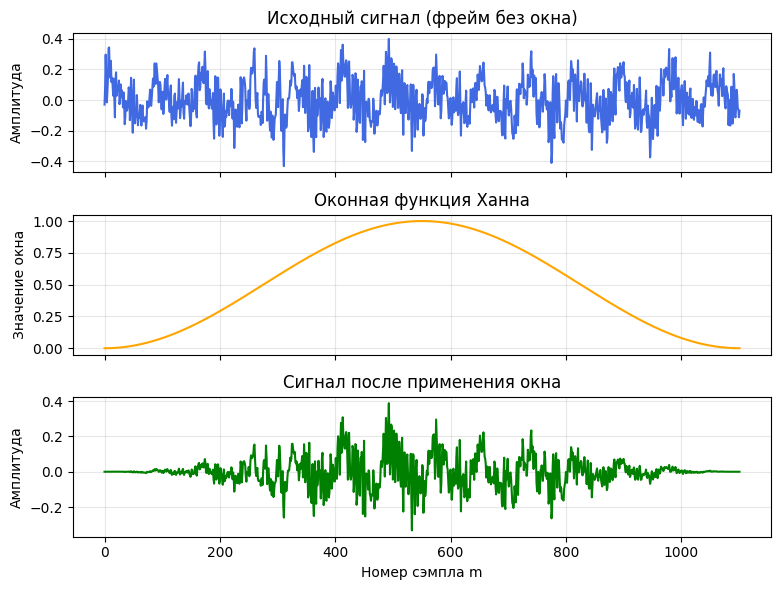

In [20]:
def apply_hann_window(frames, window_length):
    """Применяем окно Ханна ко всем фреймам.
    frames: np.ndarray формы (n_frames, window_length)
    return: (window, windowed_frames)
    """
    m = np.arange(window_length)
    window = (1 - np.cos(2 * np.pi * m / (max(window_length - 1, 1)))) / 2
    return window, frames * window


w_hann, s_w = apply_hann_window(s, L)


# Визуализация
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# Исходный сигнал
i = 100  # номер окна
axes[0].plot(s[i], color='royalblue')
axes[0].set_title("Исходный сигнал (фрейм без окна)")
axes[0].set_ylabel("Амплитуда")
axes[0].grid(alpha=0.3)

# Оконная функция
axes[1].plot(w_hann, color='orange')
axes[1].set_title("Оконная функция Ханна")
axes[1].set_ylabel("Значение окна")
axes[1].grid(alpha=0.3)

# Сигнал после применения окна
axes[2].plot(s_w[i], color='green')
axes[2].set_title("Сигнал после применения окна")
axes[2].set_xlabel("Номер сэмпла m")
axes[2].set_ylabel("Амплитуда")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


### 4. Быстрое преобразование Фурье

In [21]:
def compute_stft(frames, n_fft, sample_rate):
    """Рассчитываем спектр, частоты, амплитуду и мощность для каждого окна."""
    spectrogram = np.array([np.fft.rfft(frame, n=n_fft) for frame in frames])
    freqs = np.fft.rfftfreq(n_fft, d=1 / sample_rate)
    amplitude = np.abs(spectrogram)
    power = (amplitude ** 2) / n_fft
    return spectrogram, freqs, amplitude, power


spectrogram, freqs, amplitude, power = compute_stft(s_w, N_FFT, fs)


In [22]:
# амплитуда и мощность возвращаются функцией compute_stft
amplitude.shape, power.shape


((951, 1025), (951, 1025))

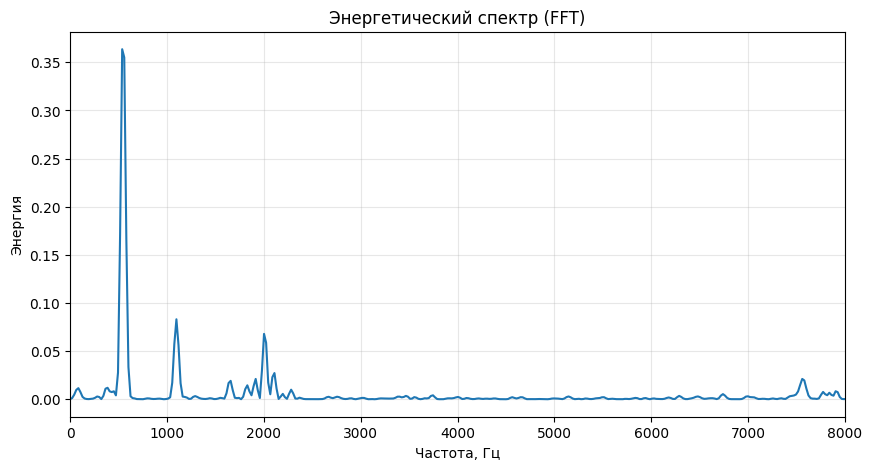

In [23]:
# визуализация

plt.figure(figsize=(10, 5))
plt.plot(freqs, power[i])  # на примере i-го окна
plt.title("Энергетический спектр (FFT)")
plt.xlabel("Частота, Гц")
plt.ylabel("Энергия")
plt.xlim(0, 8000)   # ограничим для наглядности
plt.grid(alpha=0.3)
plt.show()

### 5. Преобразование к mel-шкале

In [24]:
def hz_to_mel(f):
    return 1127.0 * np.log(1.0 + (f / 700.0))

def mel_to_hz(m):
    return 700.0 * (np.exp(m / 1127.0) - 1.0)

def build_mel_filterbank(freq_hz, M=40, fmin=50.0, fmax=None, norm="slaney"):
    """
    freq_hz: 1D массив частотных бинов (Гц) длины K (например, np.fft.rfftfreq(...))
    M:       число mel-фильтров
    fmin:    нижняя граница в Гц
    fmax:    верхняя граница в Гц (по умолчанию последняя частота из freq_hz)
    norm:    "htk" (вершина=1) или "slaney" (площадь=1)
    return:  H, матрица формы (M, K)
    """
    K = freq_hz.size
    if fmax is None:
        fmax = freq_hz.max()

    # 1. границы в mel
    m_min = hz_to_mel(fmin)
    m_max = hz_to_mel(fmax)

    # 2. равномерные узлы на mel: M+2 точек (включая края)
    m_points = np.linspace(m_min, m_max, M + 2)

    # 3. обратно в Гц: f_0 ... f_{M+1}
    f_points = mel_to_hz(m_points)

    # 4. для удобства: три сегмента на каждый фильтр i=1..M
    H = np.zeros((M, K), dtype=np.float64)

    for i in range(1, M + 1):
        f_left  = f_points[i - 1]
        f_center= f_points[i]
        f_right = f_points[i + 1]

        # возрастающая часть (f_left -> f_center)
        left_mask = (freq_hz >= f_left) & (freq_hz <= f_center)
        H[i - 1, left_mask] = (freq_hz[left_mask] - f_left) / (f_center - f_left)

        # убывающая часть (f_center -> f_right)
        right_mask = (freq_hz >= f_center) & (freq_hz <= f_right)
        H[i - 1, right_mask] = (f_right - freq_hz[right_mask]) / (f_right - f_center)

    # 5. нормализация
    if norm.lower() == "htk":
        # ничего не делаем: вершина каждого треугольника = 1
        pass
    elif norm.lower() == "slaney":
        # масштабируем так, чтобы площадь каждого треугольника ~ 1
        # дискретная площадь ~ сумма по частотам с учетом шага по частоте
        df = np.mean(np.diff(freq_hz))  # шаг по частоте
        area = H.sum(axis=1, keepdims=True) * df / 2
        H = H * (2.0 / np.maximum(area, 1e-12))
    else:
        raise ValueError("norm must be 'htk' or 'slaney'")

    return H


In [25]:
def mel_spectrogram_from_power(power, freq_hz, M=40, fmin=50.0, fmax=None, 
                               norm="slaney", log=True, eps=1e-10):
    """
    power:   1D (K,) или 2D (K, N) спектр мощности |X|^2/N_FFT
             K — число частотных бинов, N — число окон
    freq_hz: 1D (K,) частоты в герцах, соответствующие power по оси K
    return:  S_mel (M, N) или (M,) если вход был (K,)
    """
    P = np.asarray(power)
    if P.ndim == 1:
        P = P[:, None]  # приведём к (K, 1) для унификации

    H = build_mel_filterbank(freq_hz, M=M, fmin=fmin, fmax=fmax, norm=norm)  # (M, K)
    S_mel = H @ P  # (M, N)

    if log:
        S_mel = np.log(S_mel + eps)

    return S_mel.squeeze(), H


In [26]:
# power: (K, N) — спектр мощности для всех окон
# freqs: (K,)   — частоты Гц (из np.fft.rfftfreq(N_FFT, 1/fs))

S_mel, H = mel_spectrogram_from_power(power.T, freqs, M=M, fmin=f_min, fmax=f_max, norm="slaney", log=True)

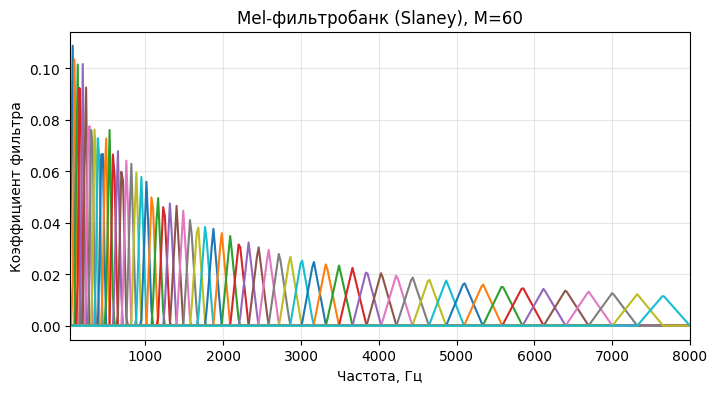

In [27]:
# фильтробанк
plt.figure(figsize=(8, 4))
plt.plot(freqs, H.T)
plt.title("Mel-фильтробанк ({}), M={}".format("Slaney", H.shape[0]))
plt.xlabel("Частота, Гц")
plt.ylabel("Коэффициент фильтра")
plt.xlim(f_min, f_max)
plt.grid(alpha=0.3)
plt.show()


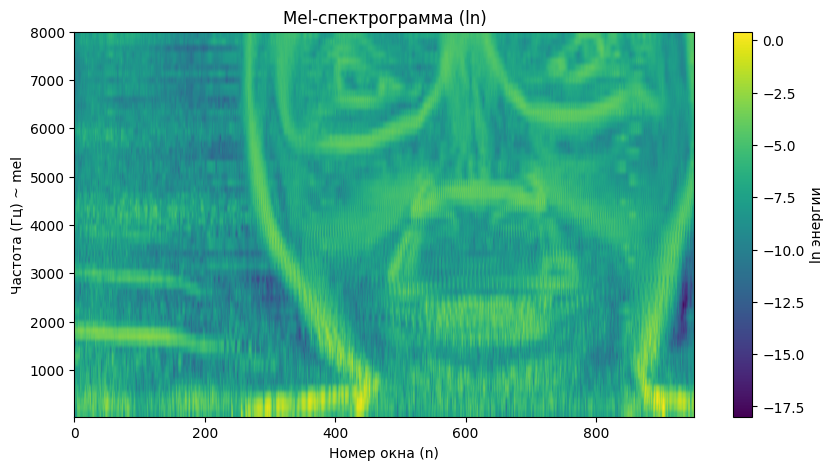

In [28]:
# mel-спектрограмма
plt.figure(figsize=(10, 5))
plt.imshow(S_mel, origin='lower', aspect='auto',
           extent=[0, S_mel.shape[1], f_min, f_max])
plt.title("Mel-спектрограмма (ln)")
plt.xlabel("Номер окна (n)")
plt.ylabel("Частота (Гц) ~ mel")
plt.colorbar(label="ln энергии")
plt.show()